# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm.auto as tqdm
%matplotlib widget

In [2]:
def grab(x):
    return x.detach().numpy()

# Brief ML primer

Let's quickly demonstrate how training looks in Pytorch. We will train a small neural network to model the function
$$
f(x) = \mathrm{sinc}(x) := \frac{\sin(\pi x)}{\pi x}
$$

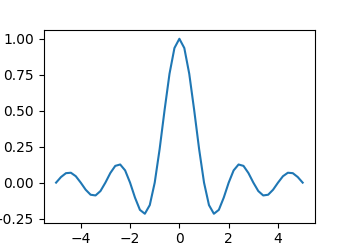

In [3]:
def target_fn(x):
    return torch.sinc(x)
fig, ax = plt.subplots(1,1, figsize=(3.5, 2.5))
xs = torch.linspace(-5, 5, steps=51)
ys = target_fn(xs)
ax.plot(grab(xs), grab(ys))
plt.show()

In [4]:
class ToyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(1, 8),
            torch.nn.SiLU(),
            torch.nn.Linear(8, 8),
            torch.nn.SiLU(),
            torch.nn.Linear(8, 1)
        )
    def forward(self, x):
        return self.net(x[:,None])[:,0]

In [5]:
def train_model():
    model = ToyModel()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    batch_size = 32
    hist = []
    for i in tqdm.tqdm(range(1000)):
        opt.zero_grad()
        x = torch.randn((batch_size,))
        y = target_fn(x)
        ymodel = model.forward(x)
        loss = ((y - ymodel)**2).mean()
        loss.backward()
        hist.append(grab(loss))
        opt.step()
    return dict(model=model, hist=np.stack(hist))
res = train_model()

  0%|          | 0/1000 [00:00<?, ?it/s]

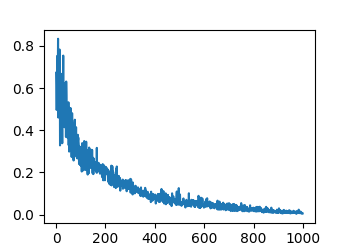

In [6]:
fig, ax = plt.subplots(1,1, figsize=(3.5, 2.5))
ax.plot(res['hist'])
plt.show()

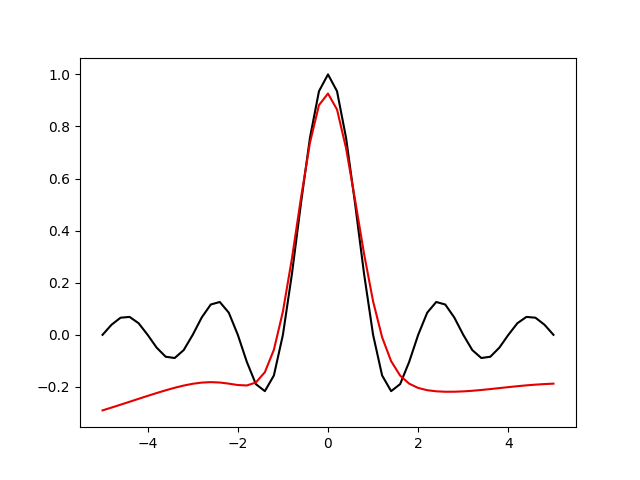

In [7]:
fig, ax = plt.subplots(1,1)
xs = torch.linspace(-5, 5, steps=51)
ys = target_fn(xs)
with torch.no_grad():
    model_ys = res['model'].forward(xs)
ax.plot(grab(xs), grab(ys), color='k')
ax.plot(grab(xs), grab(model_ys), color='xkcd:red')
plt.show()

# Target

To explore learned flows, we will use a standard 2D target, a **mixture of Gaussians**:
$$
p(x) = \frac{1}{\sqrt{2\pi}} \sum_i \sigma(\alpha)_i e^{-(x-\mu_i)^2/2}.
$$
Above, $\sigma(\alpha)_i := e^{\alpha_i} / \sum_j e^{\alpha_j}$ is the Softmax function, which maps a vector $\vec{\alpha}$ to positive-definite and normalized weights.

In [11]:
class MixtureOfGaussians:
    def __init__(self, mu, alpha):
        self.mu = mu
        self.alpha = alpha
        self.logw = torch.nn.functional.log_softmax(alpha, dim=0)
    def sample(self, batch_size):
        x = torch.randn((batch_size,2))
        i = np.arange(len(self.logw))
        inds = np.random.choice(i, size=batch_size, p=np.exp(grab(self.logw)))
        # this indexing trick extracts the full 2d vectors at inds (see below)
        return x + self.mu[inds[:,None], np.arange(2)]
    def log_prob(self, x):
        log_pi = -((x - self.mu)**2 / 2).sum(-1) + self.logw
        return -0.5 * np.log(2*np.pi) + torch.logsumexp(log_pi, dim=0)

In [ ]:
# this is an indexing trick that will be useful
a = np.arange(24).reshape(6, 4)
inds = np.array([1, 4, 3])
# this pulls rows "inds" out of a
extracted = a[inds[:,None], np.arange(4)]
print(f'{a=}')
print(' -> ')
print(f'{extracted=}')

x_mesh.shape=(2601, 2)
logp.shape=torch.Size([2601])


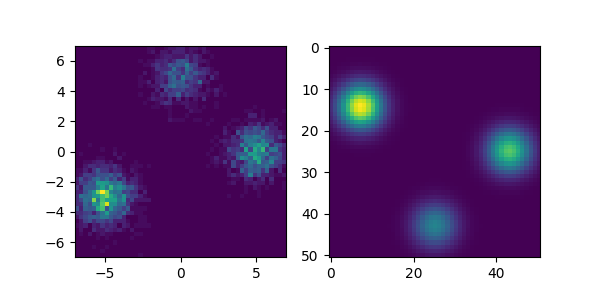

In [18]:
# some reasonable parameters for the MoG
mu = torch.tensor([
    [5., 0.],
    [0, 5.],
    [-5., -3.]
])
alpha = torch.tensor([0.5, 0.0, 0.8])
target = MixtureOfGaussians(mu, alpha)

x = grab(target.sample(4096))
fig, axes = plt.subplots(1,2, figsize=(6, 3))

ax = axes[0]
bins = np.linspace(-7, 7, num=51)
ax.hist2d(x[:,0], x[:,1], bins=bins)
ax.set_aspect(1.0)

ax = axes[1]
x_mesh = np.stack(np.meshgrid(bins, bins), axis=-1)
x_mesh = x_mesh.reshape(-1, 2)
print(f'{x_mesh.shape=}')
logp = torch.func.vmap(target.log_prob)(torch.tensor(x_mesh))
print(f'{logp.shape=}')
logp = grab(logp).reshape(51, 51)
ax.imshow(np.exp(logp))

plt.show()

# Flow model

In [26]:
class Velocity(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(3, 8),
            torch.nn.SiLU(),
            torch.nn.Linear(8, 8),
            torch.nn.SiLU(),
            torch.nn.Linear(8, 2)
        )

    def value(self, x, t):
        inp = torch.cat([x, t[None]])
        return self.net(inp[None])[0]

    def div(self, x, t):
        J = torch.func.jacfwd(self.value, argnums=0)(x, t)
        return torch.trace(J)

From Lecture 1:

In [27]:
def flow(x, velocity, *, n_step, tf=1.0, inverse=False):
    dt = tf/n_step
    ts = dt*torch.arange(n_step)
    logJ = torch.tensor(0.0)
    sign = 1
    if inverse:
        sign = -1
        ts = reversed(ts)
    for t in ts:
        # transport samples
        x = x + sign * dt * velocity.value(x, t)
        # estimate change of measure
        logJ = logJ + dt * velocity.div(x, t)
    return x, logJ

In [28]:
velocity = Velocity()
xr = torch.randn((2,))
print(flow(xr, velocity, n_step=100, tf=1.0))

(tensor([1.8557, 0.5207], grad_fn=<AddBackward0>), tensor(0.0270, grad_fn=<AddBackward0>))


**Training:** Reverse KL divergence between target and model.

In [30]:
def train_model_rkl():
    model = Velocity()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    batch_size = 32
    hist = []
    for i in tqdm.tqdm(range(1000)):
        opt.zero_grad()
        xr = torch.randn((batch_size, 2))
        logr = -((xr**2)/2).sum(-1)
        x, logJ = torch.func.vmap(flow, in_dims=(0, None))(xr, model, n_step=10)
        logp = torch.func.vmap(target.log_prob)(x)
        logq = logr - logJ
        loss = (logq - logp).mean()
        loss.backward()
        hist.append(grab(loss))
        opt.step()
    return dict(model=model, hist=np.stack(hist))
res_rkl = train_model_rkl()

  0%|          | 0/1000 [00:00<?, ?it/s]

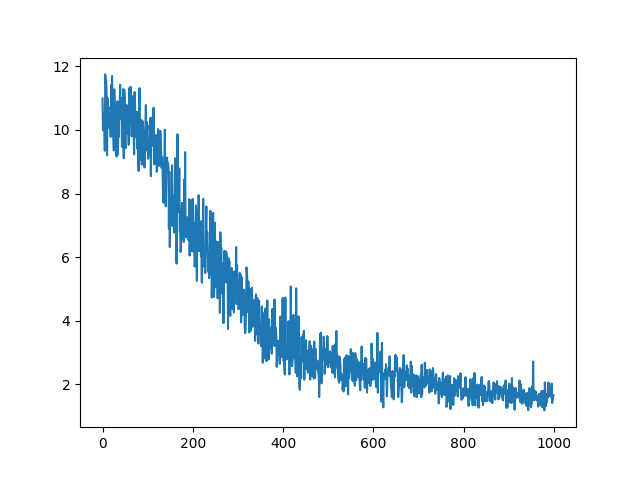

In [31]:
fig, ax = plt.subplots(1,1)
ax.plot(res_rkl['hist'])
plt.show()

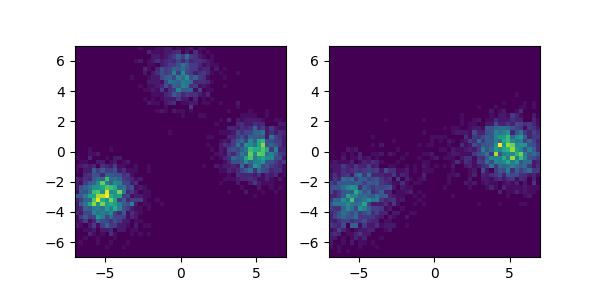

In [32]:
x = grab(target.sample(4096))
fig, axes = plt.subplots(1,2, figsize=(6, 3))

ax = axes[0]
bins = np.linspace(-7, 7, num=51)
ax.hist2d(x[:,0], x[:,1], bins=bins)
ax.set_aspect(1.0)

ax = axes[1]
bins = np.linspace(-7, 7, num=51)
xr = torch.randn((4096, 2))
x, logJ = torch.func.vmap(flow, in_dims=(0, None))(xr, res_rkl['model'], n_step=100)
x = grab(x)
ax.hist2d(x[:,0], x[:,1], bins=bins)
ax.set_aspect(1.0)

plt.show()